<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/radon_dataset/dnn_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip show keras-tuner autokeras scikit-learn

Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, joblib, scipy
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, imbalanced-learn, fancyimpute


In [2]:
import datetime
import os
import pprint

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, Input, layers, optimizers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## データセット読み込み
- radonデータセット[https://www.tensorflow.org/datasets/catalog/radon](https://www.tensorflow.org/datasets/catalog/radon)

In [3]:
def fetch_tf_dataset(data_name, 
                     split='train',
                     shuffle_files=True, as_supervised=True,
                     with_info=True, batch_size=None):
  '''TensorFlowデータセットからデータをフェッチ'''
  dataset, data_info = tfds.load(data_name, split=split,
                                  shuffle_files=shuffle_files,
                                  as_supervised=as_supervised,
                                  with_info=with_info,
                                  batch_size=batch_size)
  return dataset, data_info
  


data_name = 'radon' # @param{type:'string'}
x_name = 'features' # @param{type:'string'}
y_name = 'activity' # @param{type:'string'}
# インメモリでデータを読み込む
batch_size = -1

# データのフェッチ
tf_dataset, ds_info = fetch_tf_dataset(data_name=data_name,
                                     as_supervised=False,
                                     batch_size=batch_size)

display(ds_info)

Shuffling and writing examples to /root/tensorflow_datasets/radon/1.0.0.incompleteGVGY2A/radon-train.tfrecord


Dataset radon downloaded and prepared to /root/tensorflow_datasets/radon/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='radon',
    version=1.0.0,
    description='Radon is a radioactive gas that enters homes through contact
points with the ground. It is a carcinogen that is the primary cause of lung
cancer in non-smokers. Radon levels vary greatly from household to household.
This dataset contains measured radon levels in U.S homes by county and state.
The 'activity' label is the measured radon concentration in pCi/L. Important
predictors are 'floor' (the floor of the house in which the measurement was
taken), 'county' (the U.S. county in which the house is located), and 'Uppm' (a
measurement of uranium level of the soil by county).',
    homepage='http://www.stat.columbia.edu/~gelman/arm/examples/radon/',
    features=FeaturesDict({
        'activity': tf.float32,
        'features': FeaturesDict({
            'Uppm': tf.float32,
            'adjwt': tf.float32,
            'basement': tf.string,
            'cntyfips': tf.int32,
            'county': tf.string,
      

### Dataframeに変換

In [4]:
%%time

def convert_tfds_to_df(tf_ds, x_key, y_key):
  '''tf DatasetをDataframeに変換'''
  
  # yについて{key:numpy}形式のdictに変換
  y = {}
  y[y_key] = tf_ds[y_key].numpy()

  # xについて[{key:numpy},{key:numpy},,,]形式のdictに変換
  x = {}
  for f_key, element in tf_ds[x_key].items():
    if element.dtype == 'string':
      x[f_key] = _convert_byte_np_to_string_np(bytes_np=element.numpy())
    else:
      x[f_key] = element.numpy()
  
  y_df = pd.DataFrame.from_dict(y)
  x_df = pd.DataFrame.from_dict(x)
  df = pd.concat([y_df, x_df], axis=1)

  return df


def _convert_byte_np_to_string_np(bytes_np, decode_char='utf-8'):
  '''バイナリ文字列形式のnumpy配列を文字列形式のnumpy配列に変換'''
  decode_np = np.array([])
  for b in bytes_np:
    decode_np = np.append(decode_np, b.decode(decode_char))
  decode_np = decode_np.astype('unicode')
  return decode_np



# tf datasetからDataframeに変換
dataset = convert_tfds_to_df(tf_dataset, x_key=x_name, y_key=y_name)


display(dataset.head())
display(dataset.shape)


# カラム名の設定
y_col = y_name
x_cols = dataset.drop(columns=y_col).columns

display('y_col:{}'.format(y_col))
display('x_cols num:{}, names:{}'.format(len(x_cols), x_cols))

,activity,Uppm,adjwt,basement,cntyfips,county,dupflag,floor,idnum,lat,lon,pcterr,region,rep,room,startdt,starttm,state,state2,stfips,stopdt,stoptm,stratum,typebldg,wave,windoor,zip,zipflag
0,1.6,2.49759,292.219543,N,3,ALLEN,0,1,1681,41.091000,-85.067001,12.7,2,3,2,11489,2230,IN,IN,18,11689,2235,2,1,92,,46835,0
1,0.5,2.66527,364.958313,N,25,YAVAPAI,0,1,1457,34.599998,-112.554001,0.0,2,5,2,22688,833,AZ,AZ,4,22888,1010,2,1,56,,86325,0
2,3.0,2.43343,626.564575,Y,17,MIDDLESEX,0,0,4224,42.485001,-71.391998,9.7,6,1,2,32288,1000,MA,MA,25,32488,1000,1,1,23,,1778,0
3,0.6,2.43343,570.611755,N,17,MIDDLESEX,0,1,4094,42.485001,-71.391998,27.6,6,3,3,32488,700,MA,MA,25,32688,1200,1,1,62,,1432,0
4,1.2,2.10811,426.798859,Y,95,JACKSON,0,0,6849,39.007999,-94.347000,23.5,1,3,4,32288,605,MO,MO,29,32488,610,2,1,91,,64134,0


(12573, 28)

'y_col:activity'

"x_cols num:27, names:Index(['Uppm', 'adjwt', 'basement', 'cntyfips', 'county', 'dupflag', 'floor',\n       'idnum', 'lat', 'lon', 'pcterr', 'region', 'rep', 'room', 'startdt',\n       'starttm', 'state', 'state2', 'stfips', 'stopdt', 'stoptm', 'stratum',\n       'typebldg', 'wave', 'windoor', 'zip', 'zipflag'],\n      dtype='object')"

CPU times: user 9.68 s, sys: 296 ms, total: 9.97 s
Wall time: 9.98 s


## 文字列をone-hotエンコード

In [5]:
%%time

def one_hot_encode_df_val(df, target_col):
  '''文字列のカラムをone-hot-encodeしたカラムに置き換え
  INFO :　新規のカラムは先頭に挿入していく
  WARNING : target_colはdropされる
  '''
  mlb = MultiLabelBinarizer()
  one_hot_feature = mlb.fit_transform([{str(val)} for val in df[target_col].values])
  insert_columns = [target_col+'_'+str(x+1) for x in range(len(one_hot_feature[0]))]
  insert_df = pd.DataFrame(one_hot_feature, columns=insert_columns)
  df = df.drop(columns=target_col)
  df = pd.concat([insert_df, df], axis=1)
  return df

encode_cols = ['basement', 'county', 'state', 'state2', 'windoor']
for col in encode_cols:
  dataset = one_hot_encode_df_val(dataset, col)
display(dataset.head())


# カラム名の設定
y_col = y_name
x_cols = dataset.drop(columns=y_col).columns

display('y_col:{}'.format(y_col))
display('x_cols num:{}, names:{}'.format(len(x_cols), x_cols))

,windoor_1,state2_1,state2_2,state2_3,state2_4,state2_5,state2_6,state2_7,state2_8,state2_9,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,county_1,county_2,county_3,county_4,county_5,county_6,county_7,county_8,county_9,county_10,county_11,county_12,county_13,county_14,county_15,county_16,county_17,county_18,county_19,county_20,county_21,county_22,...,county_374,county_375,county_376,county_377,county_378,county_379,county_380,county_381,county_382,county_383,county_384,county_385,county_386,basement_1,basement_2,basement_3,basement_4,activity,Uppm,adjwt,cntyfips,dupflag,floor,idnum,lat,lon,pcterr,region,rep,room,startdt,starttm,stfips,stopdt,stoptm,stratum,typebldg,wave,zip,zipflag
0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.6,2.49759,292.219543,3,0,1,1681,41.091000,-85.067001,12.7,2,3,2,11489,2230,18,11689,2235,2,1,92,46835,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.5,2.66527,364.958313,25,0,1,1457,34.599998,-112.554001,0.0,2,5,2,22688,833,4,22888,1010,2,1,56,86325,0
2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.0,2.43343,626.564575,17,0,0,4224,42.485001,-71.391998,9.7,6,1,2,32288,1000,25,32488,1000,1,1,23,1778,0
3,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.6,2.43343,570.611755,17,0,1,4094,42.485001,-71.391998,27.6,6,3,3,32488,700,25,32688,1200,1,1,62,1432,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.2,2.10811,426.798859,95,0,0,6849,39.007999,-94.347000,23.5,1,3,4,32288,605,29,32488,610,2,1,91,64134,0


'y_col:activity'

"x_cols num:430, names:Index(['windoor_1', 'state2_1', 'state2_2', 'state2_3', 'state2_4', 'state2_5',\n       'state2_6', 'state2_7', 'state2_8', 'state2_9',\n       ...\n       'startdt', 'starttm', 'stfips', 'stopdt', 'stoptm', 'stratum',\n       'typebldg', 'wave', 'zip', 'zipflag'],\n      dtype='object', length=430)"

CPU times: user 484 ms, sys: 44.4 ms, total: 529 ms
Wall time: 528 ms


## データ分割

In [6]:
SEED = 7 #@param{type:'number'}
X_train, X_test, y_train, y_test = train_test_split(dataset[x_cols].values, dataset[y_col].values,
                                                    test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2, random_state=SEED)
display(X_train.shape, y_train.shape)
display(X_val.shape, y_val.shape)
display(X_test.shape, y_test.shape)

(8046, 430)

(8046,)

(2012, 430)

(2012,)

(2515, 430)

(2515,)

## 回帰モデル作成

In [7]:
def model_fn(input_shape, dropout_seed, X_train):
    '''モデルの定義'''

    def _DNNModel_fn(input_shape, dropout_seed, X_train):
        '''DNNモデルの定義'''

        def _initialize_std_layer(X_train):
            '''標準化層の初期化'''
            norm_layer = Normalization()
            norm_layer.adapt(X_train)
            return norm_layer
        
        dnn_model = Sequential()
        dnn_model.add(Input(shape=input_shape))
        
        # 標準化レイヤーの追加
        std_layer = _initialize_std_layer(X_train)
        dnn_model.add(std_layer)

        # データ解析レイヤーの追加
        dnn_model.add(layers.Dense(units=512, activation='relu'))
        dnn_model.add(layers.Dropout(rate=0.3, seed=dropout_seed))
        dnn_model.add(layers.Dense(units=256, activation='relu'))
        dnn_model.add(layers.Dropout(rate=0.3, seed=dropout_seed))
        dnn_model.add(layers.Dense(units=512, activation='relu'))
        dnn_model.add(layers.Dropout(rate=0.3, seed=dropout_seed))
        dnn_model.add(layers.Dense(units=256, activation='relu'))
        dnn_model.add(layers.Dropout(rate=0.3, seed=dropout_seed))
        dnn_model.add(layers.Dense(units=128, activation='relu'))
        dnn_model.add(layers.Dropout(rate=0.3, seed=dropout_seed))

        # 出力レイヤーの追加
        dnn_model.add(layers.Dense(units=1))
        return dnn_model

    model = _DNNModel_fn(input_shape=input_shape,
                         dropout_seed=dropout_seed,
                         X_train=X_train)

    # 勾配アルゴリズム(線形モデル用, 深層モデル用), 損失関数, 評価関数
    model.compile(optimizer='adam',loss='mse', metrics=['mse'])
    
    return model


input_shape = X_train.shape[1]
regressor = model_fn(input_shape=input_shape,
                     dropout_seed=None,
                     X_train=X_train)

# 各モデルのepoch数
EPOCH =  200#@param{type:'number'}

# 早期停止コールバックの定義
es = EarlyStopping(monitor='val_loss',
                   patience=2)

In [41]:
def build_model(input_shape):
  model = Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer='adam',
                metrics='mse')
  return model


input_shape = X_train.shape[1]
regressor = build_model(input_shape=input_shape)

In [42]:
%%time
regressor.fit(x=X_train, y=y_train,
              epochs=EPOCH,
              batch_size=256,
              validation_data=(X_val, y_val),
              callbacks=[es]
              )

Epoch 1/200
32/32 [==============================] - 0s 8ms/step - loss: 78233.9609 - mse: 78233.9609 - val_loss: 633.7976 - val_mse: 633.7976
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 464.7011 - mse: 464.7011 - val_loss: 152.1506 - val_mse: 152.1506
Epoch 3/200
32/32 [==============================] - 0s 4ms/step - loss: 126.8422 - mse: 126.8422 - val_loss: 126.2085 - val_mse: 126.2085
Epoch 4/200
32/32 [==============================] - 0s 4ms/step - loss: 118.1189 - mse: 118.1189 - val_loss: 89.7852 - val_mse: 89.7852
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 105.0531 - mse: 105.0531 - val_loss: 98.3367 - val_mse: 98.3367
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 109.4003 - mse: 109.4003 - val_loss: 84.8154 - val_mse: 84.8154
Epoch 7/200
32/32 [==============================] - 0s 4ms/step - loss: 148.2104 - mse: 148.2104 - val_loss: 110.8570 - val_mse: 110.8570
Epoch 8/200
32/32 [==========

In [43]:
regressor.predict(X_val)

array([[ 3.5237083],
       [ 3.2736015],
       [12.946972 ],
       ...,
       [ 4.9672966],
       [ 2.4153557],
       [ 1.8694572]], dtype=float32)

# ベストなモデルの可視化

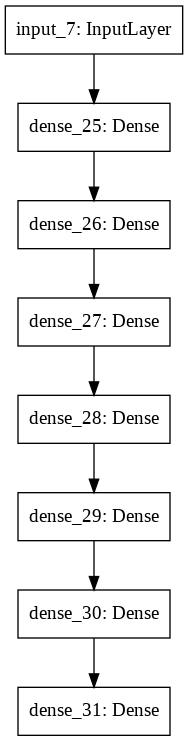

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               220672    
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                

None

In [44]:
def display_model(model):
    '''モデルの構造を表示'''
    display(plot_model(model))
    display(model.summary())


display_model(model=regressor)

## モデルの評価

### Kerasの組み込み評価関数

In [47]:
%%time
score = regressor.evaluate(x=X_test, y=y_test, batch_size=256)
display('loss : {}, mse : {}'.format(score[0], score[1]))

10/10 [==============================] - 0s 2ms/step - loss: 102.6442 - mse: 102.6442


'loss : 102.6441650390625, mse : 102.6441650390625'

CPU times: user 67.7 ms, sys: 9.71 ms, total: 77.5 ms
Wall time: 73.9 ms


### sklearnの評価関数

In [46]:
%%time
def _calc_score(y_true, y_pred, sklearn_metric):
  '''sklearnの評価指標のスコアを計算'''
  score = sklearn_metric(y_true=y_true, y_pred=y_pred)
  return score


def evaluete_sk_metrics(y_true, y_pred, sklearn_metrics):
  '''sklearnの各種、評価関数を使用'''
  result = {}
  for sk_metric in sklearn_metrics:
    result[sk_metric.__name__] = _calc_score(y_true=y_true, y_pred=y_pred, sklearn_metric=sk_metric)
  return result


SK_METRICS=[r2_score, explained_variance_score, mean_squared_error]
eval_scores = {'train': {}, 'val': {}, 'test': {}}

for key, X, y_true in zip(['train', 'val', 'test'], [X_train, X_val, X_test], [y_train, y_val, y_test]):
  y_pred = regressor.predict(X)
  eval_scores[key] = evaluete_sk_metrics(y_true=y_true, y_pred=y_pred, sklearn_metrics=SK_METRICS)
pprint.pprint(eval_scores)

{'test': {'explained_variance_score': -0.26819121837615967,
          'mean_squared_error': 102.64416,
          'r2_score': -0.4630089223737941},
 'train': {'explained_variance_score': -0.15348708629608154,
           'mean_squared_error': 120.73063,
           'r2_score': -0.29721858986444305},
 'val': {'explained_variance_score': -0.2077699899673462,
         'mean_squared_error': 102.27597,
         'r2_score': -0.39030570435974754}}
CPU times: user 527 ms, sys: 58.4 ms, total: 586 ms
Wall time: 466 ms
